# Intrinsic and Extrinsic Calibration from 2D-3D Correspondences

Given a set of 2D-3D correspondences $\langle x_i, X_i \rangle \; (i=1,\dots,N)$ and an initial guess of the intrinsic parameter $K_0$, we can find $R$, $t$, and $K$ satisfying
\begin{equation}
x \sim K (R X + t)\,.
\end{equation}


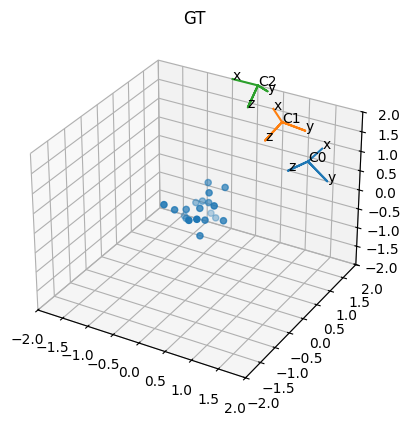

In [5]:
# Synthetic data

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

T = 20
np.random.seed(0)

def lookat(pos, eye):
    up = np.array([0, 0, 1])
    ez = eye - pos
    ez = ez / np.linalg.norm(ez)
    ex = np.cross(ez, up)
    ex = ex / np.linalg.norm(ex)
    ey = np.cross(ez, ex)
    ey = ey / np.linalg.norm(ey)
    R_c2w = np.array([ex, ey, ez])
    return R_c2w.T, pos

def plot_cam(ax, R_c2w, t_c2w, name=None, scale=0.5):
    ex = R_c2w[:,0] * scale + t_c2w
    ey = R_c2w[:,1] * scale + t_c2w
    ez = R_c2w[:,2] * scale + t_c2w
    p = np.array([ex, t_c2w, ey, t_c2w, ez, t_c2w])
    ax.plot(p[:,0], p[:,1], p[:,2])
    ax.text(p[0,0], p[0,1], p[0,2], 'x')
    ax.text(p[2,0], p[2,1], p[2,2], 'y')
    ax.text(p[4,0], p[4,1], p[4,2], 'z')
    if name is not None:
        ax.text(p[1,0], p[1,1], p[1,2], name)

# GT cameras in C2W
R1_gt, t1_gt = lookat(np.array([2, 0, 2]), np.array([0, 0, 0]))
R2_gt, t2_gt = lookat(np.array([1, 1, 2]), np.array([0, 0, 0]))
R3_gt, t3_gt = lookat(np.array([0, 2, 2]), np.array([0, 0, 0]))

# GT positions (T x 3 matrix)
X_gt = np.random.rand(T, 3) - 0.5

# GT intrinsics
K1_gt = np.array([[ 640, 0, 320], [0,  640, 240], [0, 0, 1]], dtype=np.float64)
K2_gt = np.array([[1280, 0, 640], [0, 1280, 360], [0, 0, 1]], dtype=np.float64)
K3_gt = np.array([[1920, 0, 960], [0, 1920, 540], [0, 0, 1]], dtype=np.float64)

# GT position observations (T x 3 matrix)
x1_gt = (X_gt @ R1_gt - R1_gt.T @ t1_gt) @ K1_gt.T
x2_gt = (X_gt @ R2_gt - R2_gt.T @ t2_gt) @ K2_gt.T
x3_gt = (X_gt @ R3_gt - R3_gt.T @ t3_gt) @ K3_gt.T

# verify z>0
assert np.sum(x1_gt[:,2] < 0) == 0
assert np.sum(x2_gt[:,2] < 0) == 0
assert np.sum(x3_gt[:,2] < 0) == 0

x1_gt = x1_gt / x1_gt[:,2][:,None]
x2_gt = x2_gt / x2_gt[:,2][:,None]
x3_gt = x3_gt / x3_gt[:,2][:,None]


# Visualize
def visualize(R_list, t_list, v, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for i, (R, t) in enumerate(zip(R_list, t_list)):
        plot_cam(ax, R, t, name=f'C{i}')

    ax.scatter3D(v[:,0], v[:,1], v[:,2])
    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)
    ax.set_title(title)
    plt.show()

visualize([R1_gt, R2_gt, R3_gt], [t1_gt, t2_gt, t3_gt], X_gt, 'GT')


# Case 1: Extrinsic calibration only == PnP

In [6]:
def calibRt(X, x, K, distCoeffs):
    X = np.copy(X)
    x = np.copy(x)
    ret, rvec, tvec = cv2.solvePnP(X, x, K, distCoeffs)
    rmat = cv2.Rodrigues(rvec)[0]
    return rmat, tvec, ret

# estimate
R1, t1, ret = calibRt(X_gt, x1_gt[:,:2], K1_gt, np.zeros((5,1)))

# eval
Err_R = np.linalg.norm(R1.T - R1_gt)
Err_t = np.linalg.norm(-R1.T@t1 - t1_gt.reshape((3,1)))
print(f'Error: R={Err_R}, t={Err_t}')

assert np.allclose(R1.T, R1_gt)
assert np.allclose(-R1.T@t1, t1_gt.reshape((3,1)))


Error: R=4.3709524189038457e-16, t=6.350609380905479e-16


# Case 2: Intirinsic and extrinsic calibration (w/o distortion)

In [7]:
def calibKRt(X, x, image_size, K0, distCoeffs0):
    X = np.copy(X.astype(np.float32))
    x = np.copy(x.astype(np.float32))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([X], [x], image_size, K0, distCoeffs0, flags=cv2.CALIB_USE_INTRINSIC_GUESS+cv2.CALIB_FIX_ASPECT_RATIO+cv2.CALIB_ZERO_TANGENT_DIST+cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K3)
    rvec = rvecs[0]
    tvec = tvecs[0]
    rmat = cv2.Rodrigues(rvec)[0]
    return rmat, tvec


# estimate
K0 = np.array([[1024, 0, 512], [0, 1024, 384], [0, 0, 1]], dtype=np.float64)
R1, t1 = calibKRt(X_gt, x1_gt[:,:2], (1920, 1080), K0, np.zeros(5))

# eval
Err_R = np.linalg.norm(R1.T - R1_gt)
Err_t = np.linalg.norm(-R1.T@t1 - t1_gt.reshape((3,1)))
print(f'Error: R={Err_R}, t={Err_t}')

assert np.allclose(R1.T, R1_gt, atol=1e-6)
assert np.allclose(-R1.T@t1, t1_gt.reshape((3,1)), atol=1e-6)


Error: R=4.123810692656778e-07, t=8.681321890178102e-07


# Case 3: Intrinsic and extrinsic calibration (with distortion)

In [8]:
def calibKdRt(X, x, image_size, K0, distCoeffs0):
    X = np.copy(X.astype(np.float32))
    x = np.copy(x.astype(np.float32))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([X], [x], image_size, K0, distCoeffs0, flags=cv2.CALIB_USE_INTRINSIC_GUESS+cv2.CALIB_FIX_ASPECT_RATIO)
    rvec = rvecs[0]
    tvec = tvecs[0]
    rmat = cv2.Rodrigues(rvec)[0]
    return rmat, tvec, dist


# estimate
K0 = np.array([[1024, 0, 512], [0, 1024, 384], [0, 0, 1]], dtype=np.float64)
R1, t1, distCoeffs = calibKdRt(X_gt, x1_gt[:,:2], (1920, 1080), K0, np.zeros(5))

# eval
Err_R = np.linalg.norm(R1.T - R1_gt)
Err_t = np.linalg.norm(-R1.T@t1 - t1_gt.reshape((3,1)))
print(f'Error: R={Err_R}, t={Err_t}')

assert np.allclose(R1.T, R1_gt, atol=1e-5)
assert np.allclose(-R1.T@t1, t1_gt.reshape((3,1)), atol=1e-5)


Error: R=1.4536575208261299e-06, t=5.976198327152625e-07
